# Feature Selection and Dimensionality Reduction Demo

This notebook demonstrates how to use PCA and mutual information for feature selection and dimensionality reduction on audio features.

> **Note:**
> This notebook expects a file named `batch_features.json` in the current directory, containing extracted audio features. If you do not have this file, you can generate it by running the batch extraction script from the command line:
>
> ```powershell
> # From the project root directory
> python -m AFX.cli <your_audio_folder> --config AFX/config.json --output batch_features.json --format json
> ```

In [ ]:
import numpy as np
import pandas as pd
from AFX.utils.selectors import pca_reducer, mutual_info_selector, correlation_selector

# Load a previously extracted feature set (from batch demo)
df = pd.read_json('../batch_features.json').T.reset_index(drop=True)

# Drop non-numeric columns and missing values
feature_cols = [col for col in df.columns if col not in ['file', 'error']]
df = df.dropna(subset=feature_cols)
X = df[feature_cols].values

In [4]:
df

,zcr,variance,spectral_centroid,spectral_bandwidth,spectral_rolloff,melspectrogram,mfcc,mfcc_delta,chroma_cqt,pitch,thd,hnr
0,"[0.09716796875, 0.1044921875, 0.11474609374999...",[0.0022030426189300002],"[1377.7790945041054, 1238.2700642569018, 1180....","[1947.5842458209252, 1738.7225279804752, 1604....","[2541.873584273299, 2183.326639931583, 2103.69...","[0.02117409184575, 0.027825558558106003, 0.026...","[-419.9195251464844, -400.9195251464844, -408....","[-0.353333503007888, -0.353333503007888, -0.35...","[0.642763793468475, 0.6357790827751161, 0.6345...","[329.06211496801427, 337.81937460910484, 333.5...",[0.904148697853088],[18.672826766967773]
1,"[0.0205078125, 0.03173828125, 0.04296875, 0.04...",[0.002260117791593],"[1356.8606624100562, 1201.5037277470462, 1130....","[1926.7154078625006, 1683.8460217640425, 1518....","[2436.946999815089, 2031.5111871301774, 1953.7...","[0.021299656480550003, 0.028564205393195003, 0...","[-414.5635070800781, -400.49871826171875, -411...","[-1.203613042831421, -1.203613042831421, -1.20...","[0.637114465236663, 0.6228567361831661, 0.6237...","[362.8843257904831, 366.5579393252777, 363.472...",[0.683759987354278],[18.813617706298828]
2,"[0.0, 0.0, 0.03271484375, 0.09130859375, 0.154...",[0.004939044825732],"[1846.9992270090593, 1751.5651854517155, 1734....","[2335.933122088779, 2124.2362558278137, 2004.7...","[3850.4058837890625, 3388.451385498047, 3184.8...","[24.804506301879883, 27.460018157958984, 22.12...","[-235.103759765625, -255.1435546875, -328.6783...","[-0.37291520833969105, -0.37291520833969105, -...","[0.47981128096580505, 0.41066563129425004, 0.3...","[1677.0517696022007, 1623.2279804749892, 1542....",[1.214024305343628],[19.891204833984375]


## Dimensionality Reduction with PCA

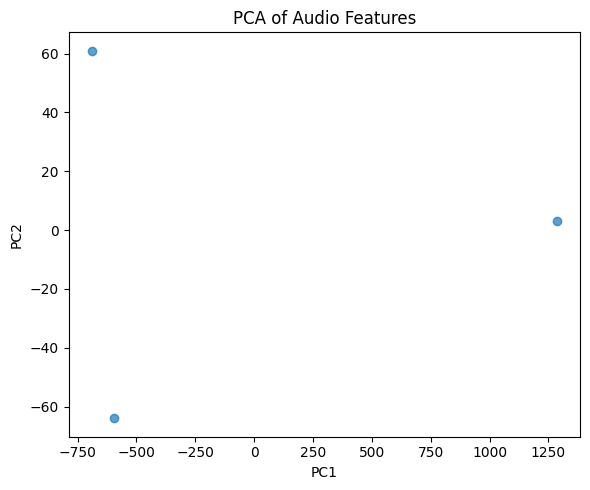

In [5]:
# Reduce to 2 principal components for visualization
#X_pca, pca = pca_reducer({k: df[k].values for k in feature_cols}, n_components=2)

# Flatten features: if a value is a list/array, take its mean; else use as is
flat_features = {}
for k in feature_cols:
    flat_features[k] = df[k].apply(lambda v: np.mean(v) if isinstance(v, (list, np.ndarray)) else v)
X_flat = pd.DataFrame(flat_features).values

X_pca, pca = pca_reducer({k: X_flat[:, i] for i, k in enumerate(feature_cols)}, n_components=2)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Audio Features')
plt.tight_layout()
plt.show()

## Feature Selection with Mutual Information

Suppose we have labels (e.g., class IDs) for supervised selection. Here, we simulate random labels for demonstration.

In [ ]:
# Simulate random labels (replace with real labels for the dataset)

y = np.random.randint(0, 2, size=X_flat.shape[0])
selected_idx = mutual_info_selector(X_flat, y, k=5)
selected_features = [feature_cols[i] for i in selected_idx]
print('Top 5 features by mutual information:', selected_features)

Top 5 features by mutual information: ['hnr', 'thd', 'pitch', 'chroma_cqt', 'mfcc_delta']


## Correlation-Based Feature Filtering

In [ ]:
selected_corr_idx = correlation_selector(X_flat, threshold=0.9)
selected_corr_features = [feature_cols[i] for i in selected_corr_idx]
print('Features after correlation filtering:', selected_corr_features)

Features after correlation filtering: ['zcr', 'mfcc_delta']


## Experiment: Varying Correlation Thresholds and Using Different Feature Selectors

In this section, we experiment with different correlation thresholds and compare the results of mutual information and variance threshold selectors.

In [ ]:
thresholds = [0.7, 0.8, 0.9, 0.95]
for thresh in thresholds:
    idx = correlation_selector(X_flat, threshold=thresh)
    features = [feature_cols[i] for i in idx]
    print(f'Correlation threshold {thresh}: {len(features)} features selected')

Correlation threshold 0.7: 1 features selected
Correlation threshold 0.8: 2 features selected
Correlation threshold 0.9: 2 features selected
Correlation threshold 0.95: 2 features selected


In [9]:
# Experiment: Variance threshold selector (remove low-variance features)
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X_flat)
selected_var_features = [feature_cols[i] for i in selector.get_support(indices=True)]
print(f'Features selected by variance threshold: {selected_var_features}')

Features selected by variance threshold: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'melspectrogram', 'mfcc', 'pitch', 'thd', 'hnr']


In [10]:
# Compare mutual information and variance threshold selectors
print('Top 5 features by mutual information:', selected_features)
print('Features selected by variance threshold:', selected_var_features)
common_features = set(selected_features) & set(selected_var_features)
print(f'Common features selected by both: {list(common_features)}')

Top 5 features by mutual information: ['hnr', 'thd', 'pitch', 'chroma_cqt', 'mfcc_delta']
Features selected by variance threshold: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'melspectrogram', 'mfcc', 'pitch', 'thd', 'hnr']
Common features selected by both: ['thd', 'pitch', 'hnr']
